Импортируем необходимые библиотеки

In [21]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision

Располодение датасета

In [22]:
#получим такой адрес как C:\\(папка с блокнотом)
dir = os.path.abspath(os.curdir)
# наши папки находятся в каталоге directory 
data_dir=os.path.join(dir, "datasets\\")

Трансформируем изображения нужным образом в нашем случае мы уменьшаем его до 224*224 пикселя

In [23]:
#Data scaled and normalization for training and testing for resnet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


Функция, которая преобразует картинки в массив данных для обучения

In [24]:
#Создаём функцию для получения набора данных изображений и изменения его размера в соответствии с размером модели
def get_dataset(data_dir, data_transforms ):
    # создаём тестовую и тренировочную выборки
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #получим классы из названия папок набора данных для тренировки модели
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

Классы картинок и количество в тренировочной и тестовой выборках

Classes:  ['Healthy', 'Tach']
The datasest have:  {'train': 270, 'test': 50}  images


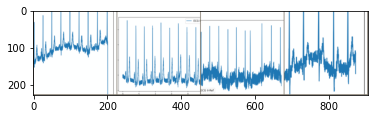

Healthy Healthy Healthy  Tach


In [26]:
#данные о выборках
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")
# Создаём новую функцию отображения изображений для новой трансформации 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # делаем небольшую паузу, позволяющую графикам обновиться
# получаем несколько случайных изображений из выборки
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()
# выводим изображения
imshow_resNet18(torchvision.utils.make_grid(images))
# и названия
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Создаём слои с различными разностями входа и выхода и функции, отвечающие за преобразования

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Каждая эпоха имеет этап обучения и проверки
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # переводим модель в режим обучения
            else:
                model.eval()   # оценка модели
            running_loss = 0.0
            running_corrects = 0
            # итерация по данным
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # обнулите градиенты параметров
                optimizer.zero_grad()
                # вперёд
                # история отслеживания если только в тренировочной
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # обратная оптимизация + только в том случае, если она находится на этапе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # глубокое копирование модели
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # загружаем лучший результат модели
    model.load_state_dict(best_model_wts)
    return model

In [28]:
# Подготовим параметры для обучения модели
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Здесь размер каждой выходной выборки установлен равным 2.
# В качестве альтернативы, это может быть обобщено на nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Все параметры оптимизируются
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Уменьшение LR в 0,1 раза каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Тренируем нашу модель

In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.8245 Acc: 0.5926
test Loss: 0.4691 Acc: 0.7400

Training complete in 1m 23s
Best val Acc: 0.740000


Визуализация результатов анализа тестовых данных

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.5823, 0.6458])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.2713, 0.1068])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.8213, 0.9455])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.6115, 0.5514])


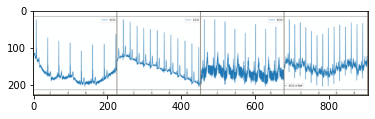

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.3278, 0.9081])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.3014, 0.6574])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.0610, 0.9979])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([0.8298, 0.0630])


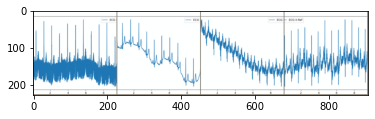

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.5481, 1.6125])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([1.3227, 1.3775])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.2207,  2.2625])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([0.3215, 0.4599])


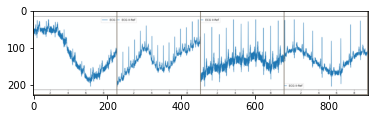

Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.4135, 0.6804])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.5013, 0.5879])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.6641, 0.7681])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.9020, 1.0346])


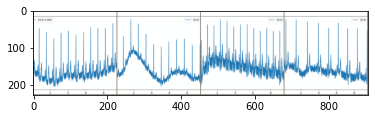

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.6661, -0.6503])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.9714, 1.0398])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([0.8170, 0.5071])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.3287, 1.1507])


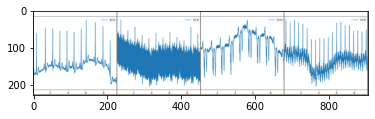

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.6995, -0.4811])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([0.9742, 0.0972])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.9483, 1.0110])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([0.0653, 1.8344])


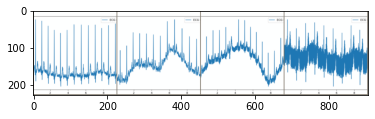

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.6182, 1.1214])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.8445, -0.1189])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.4985, 1.2937])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.0428,  3.2806])


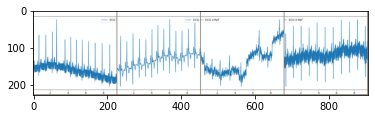

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.1658, 1.8258])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.7967, 0.0742])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.4308, -0.2499])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.8778, 0.1528])


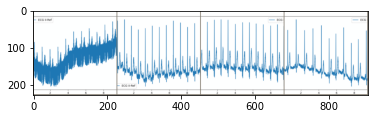

Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.4050, 0.8957])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.8296, 1.1355])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.5019, 0.6416])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([0.7879, 0.6883])


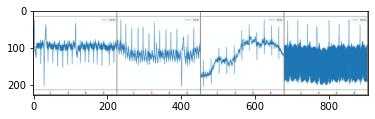

Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.1077, 0.9608])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.9418, -0.1835])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.5127, 1.0805])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.9039,  4.3893])


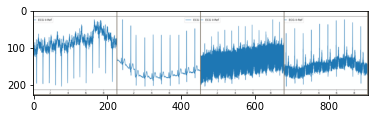

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([0.6570, 0.6415])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.6806, -0.6737])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.2851,  2.6562])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([0.6101, 0.9371])


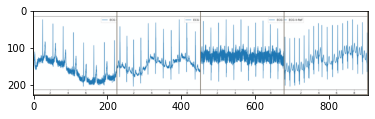

Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.0121, 0.9612])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([0.8506, 1.6129])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.4618, -0.5343])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.1652, -0.5135])


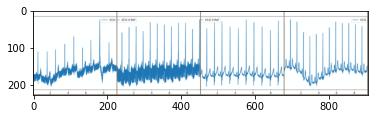

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.7592, 0.4861])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.0038, -0.9686])


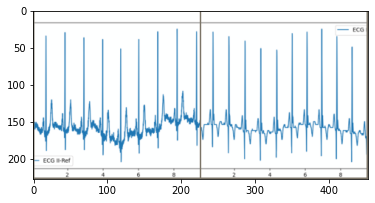

Accuracy of the network on the 50 test images: 74 %


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
      
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))